In [1]:
import nengo
import multiprocessing
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hashids import Hashids
from run_motif_search import *
import os
import scipy
from tqdm import tqdm

In [2]:
def load_file(fn):
    pass


In [3]:
# Test with leech heartbeat matrix
modules=1
module_matrix = np.array(
[
    [0,0,0,1],
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
])
lr_matrix = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,0,0,0]
])
print(list(module_matrix.ravel()), list(lr_matrix.ravel()))
ret = run_model(module_matrix,lr_matrix,metadata=[module_matrix,lr_matrix])


([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


In [4]:
mms = generate_module_matrices(4)
lrs = generate_module_matrices(4,lim=2)
for mm,lr in product(mms, lrs):
    if np.all(mm==module_matrix) and np.all(lr==lr_matrix):
        print(make_hash((mm,lr)))
        break

In [5]:
print(ret['_metadata'])
save_return(ret, path='.')

[array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]]), array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]])]


'oRcLcZcqfYfQcWcqcDcofqcXcOcncxfZcgfLc7cocrcpcVc8cRc1cWfjcQc7c6cE'

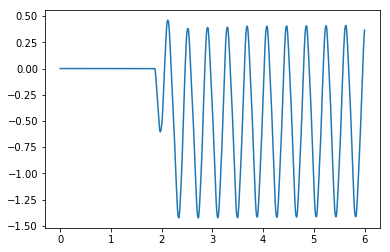

In [6]:
# Sanity check!
fig, ax = plt.subplots()
ax.plot(ret['time'], ret['motor_values'])


Text(0.5,0,'Time')

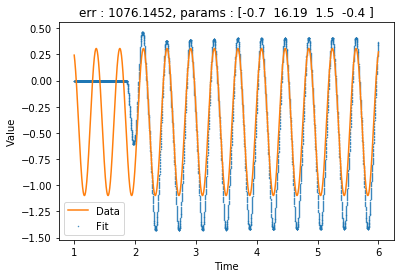

In [7]:
fig,ax = plt.subplots()
tslc = slice(1000,None)
# tslc = slice(3000,4000)
ax.scatter(ret['time'][tslc], ret['motor_values'][tslc], s=0.2)
params, cov,err,yhat = fit_curve(ret, tslc)

ax.title.set_text("err : {}, params : {}".format(np.round(err,4),np.round(params,2)))
#     params[0] = 0.001
ax.plot(ret['time'][tslc], yhat, color='tab:orange')
ax.legend(['Data','Fit'])
ax.set_ylabel('Value')
ax.set_xlabel('Time')

In [8]:
y = np.array(ret['motor_values'][tslc]).ravel()
# yhat2 = np.zeros_like(y)
yhat2 = yhat

err = (y-yhat2)**2
err = np.sqrt(err)
err.shape, err[0], np.sum(err)
# err[0]
# y-yhat2

((5000,), 0.2431170830055137, 1076.1452046544282)

(array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]]), array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]]))


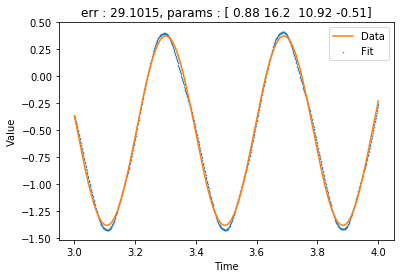

In [9]:
path = './data_s0'
# Generator over filenames so they're not loaded into memory
_fr,_dirname,files = os.walk(path).next()
files = ['oRcLcZcqfYfQcWcqcDcofqcXcOcncxfZcgfLc7cocrcpcVc8cRc1cWfjcQc7c6cE.pkl']
for i,fn in enumerate(files):
    with open(os.path.join(path,fn), 'rb') as fp:
        ret = pickle.load(fp)
    print(ret['_metadata'])
    fig, ax = plt.subplots()
    
    tslc = slice(1000,None)
    tslc = slice(3000,4000)
    ax.scatter(ret['time'][tslc], ret['motor_values'][tslc], s=0.2)
    params, cov,err,yhat = fit_curve(ret, tslc)
    ax.title.set_text("err : {}, params : {}".format(np.round(err,4),np.round(params,2)))
#     params[0] = 0.001
    ax.plot(ret['time'][tslc], yhat, color='tab:orange')
    ax.legend(['Data','Fit'])
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    
    if i > 0:
        break

        
#     with ) as fp:



In [10]:
datafiles = os.listdir(path)

In [11]:
df = pd.DataFrame(columns=['err','cov','a','b','c','e'])

In [ ]:
tslc = slice(3000,4000)
def async_fit(fn, meta):
    with open(os.path.join(path,fn), 'rb') as fp:
        ret = pickle.load(fp)
    return fit_curve(ret, tslc), meta
futures = []
pool=multiprocessing.Pool(processes=4)
for i,fn in tqdm(enumerate(datafiles), total=len(datafiles)):
    
        
    
    
    futures.append(pool.apply_async(async_fit, args=(fn,fn)))
    
pbar = tqdm(total=len(futures))
while len(futures):
    for i,f in enumerate(futures):
        if f.ready():
            (params, cov, err, yhat),fn = f.get()
            futures.pop(i)
            pbar.update(1)
            df.loc[fn, 'err'] = err
            df.loc[fn, 'cov'] = [cov]
            df.loc[fn, ['a','b','c','e']] = params
    

  2%|▏         | 2088/107848 [01:33<1:11:42, 24.58it/s]

In [ ]:
df.to_pickle('sin_fit_results_df2_s0.pkl')